# Decision Modeling Mini Sprint 
This is a notebook to document the Decision Modeling Mini Sprint from IBM Skills Build. It is a 3-week sprint where we will analyze Formula 1 race data and build a decision model. To get started running this notebook, You can install the requirements by following the instructions in the [README.md](../README.md) file in the root of this repository.

## Problem Statement
We have been tasked with analyzing the data to make predictions on which constructor will win a head-to-head matchup on a specific circuit. We will use the data provided to build a decision model that will predict the points that each constructor will score in a head-to-head matchup on a specific circuit.

In [2]:
# Set the path for our data
data_path = '../data/decision-modeling-sprint/'

In [3]:
# Unzip The data into the data path specified
zip_file = 'data.zip'
!unzip -o {data_path + zip_file} -d {data_path}

Archive:  ../data/decision-modeling-sprint/data.zip
  inflating: ../data/decision-modeling-sprint/f1db-seasons-constructor-standings.csv  
  inflating: ../data/decision-modeling-sprint/f1db-countries.csv  
  inflating: ../data/decision-modeling-sprint/f1db-races-constructor-standings.csv  
  inflating: ../data/decision-modeling-sprint/f1db-races-race-results.csv  
  inflating: ../data/decision-modeling-sprint/f1db-races-sprint-race-results.csv  
  inflating: ../data/decision-modeling-sprint/f1db-races-starting-grid-positions.csv  
  inflating: ../data/decision-modeling-sprint/f1db-races-pre-qualifying-results.csv  
  inflating: ../data/decision-modeling-sprint/f1db-constructors.csv  
  inflating: ../data/decision-modeling-sprint/f1db-races-qualifying-results.csv  
  inflating: ../data/decision-modeling-sprint/f1db-races-pit-stops.csv  
  inflating: ../data/decision-modeling-sprint/f1db-engine-manufacturers.csv  
  inflating: ../data/decision-modeling-sprint/f1db-races-sprint-qualifying

In [4]:
# Here we import all our libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api import types 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor, plot_tree
from xgboost import XGBClassifier, to_graphviz, plot_importance
pd.set_option('display.max_columns', None)

# Data Cleaning and Preprocessing
In this section we will load the data into pandas data frames And cleaned the data to make it ready for analysis. We will specifically be looking at data related to constructors and their performance on circuits.

In [5]:
drivers = pd.read_csv(data_path + 'f1db-drivers.csv').replace('\\N', np.nan)
constructors = pd.read_csv(data_path + 'f1db-constructors.csv').replace('\\N', np.nan)
races = pd.read_csv(data_path + 'f1db-races.csv').replace('\\N', np.nan)
circuits = pd.read_csv(data_path + 'f1db-circuits.csv').replace('\\N', np.nan)
constructor_standings = pd.read_csv(data_path + 'f1db-races-constructor-standings.csv').replace('\\N', np.nan)
qualifying = pd.read_csv(data_path + 'f1db-races-qualifying-results.csv').replace('\\N', np.nan)
results = pd.read_csv(data_path + 'f1db-races-race-results.csv').replace('\\N', np.nan)
pit_stops = pd.read_csv(data_path + 'f1db-races-pit-stops.csv').replace('\\N', np.nan)

In [6]:
constructors.info()
constructors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        183 non-null    object 
 1   name                      183 non-null    object 
 2   fullName                  183 non-null    object 
 3   countryId                 183 non-null    object 
 4   bestChampionshipPosition  76 non-null     float64
 5   bestStartingGridPosition  172 non-null    float64
 6   bestRaceResult            153 non-null    float64
 7   totalChampionshipWins     183 non-null    int64  
 8   totalRaceEntries          183 non-null    int64  
 9   totalRaceStarts           183 non-null    int64  
 10  totalRaceWins             183 non-null    int64  
 11  total1And2Finishes        183 non-null    int64  
 12  totalRaceLaps             183 non-null    int64  
 13  totalPodiums              183 non-null    int64  
 14  totalPodiu

,id,name,fullName,countryId,bestChampionshipPosition,bestStartingGridPosition,bestRaceResult,totalChampionshipWins,totalRaceEntries,totalRaceStarts,totalRaceWins,total1And2Finishes,totalRaceLaps,totalPodiums,totalPodiumRaces,totalChampionshipPoints,totalPolePositions,totalFastestLaps
0,adams,Adams,Adams,united-states-of-america,NaN,17.0,27.0,0,1,1,0,0,108,0,0,0.0,0,0
1,afm,AFM,Alex von Falkenhausen Motorenbau,germany,NaN,9.0,9.0,0,4,4,0,0,98,0,0,0.0,0,0
2,ags,AGS,Automobiles Gonfaronnaises Sportives,france,11.0,10.0,6.0,0,80,48,0,0,2031,0,0,2.0,0,0
3,alfa-romeo,Alfa Romeo,Alfa Romeo Racing,italy,6.0,1.0,1.0,0,214,214,10,4,20608,26,18,199.0,12,16
4,alfa-special,Alfa Special,Alfa Special,south-africa,NaN,16.0,10.0,0,2,2,0,0,132,0,0,0.0,0,0


In [7]:
constructor_standings.info()
constructor_standings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10089 entries, 0 to 10088
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   raceId                10089 non-null  int64  
 1   year                  10089 non-null  int64  
 2   round                 10089 non-null  int64  
 3   positionDisplayOrder  10089 non-null  int64  
 4   positionNumber        10072 non-null  float64
 5   positionText          10089 non-null  object 
 6   constructorId         10089 non-null  object 
 7   engineManufacturerId  10089 non-null  object 
 8   points                10089 non-null  float64
 9   positionsGained       9655 non-null   float64
dtypes: float64(3), int64(4), object(3)
memory usage: 788.3+ KB


,raceId,year,round,positionDisplayOrder,positionNumber,positionText,constructorId,engineManufacturerId,points,positionsGained
0,65,1958,1,1,1.0,1,cooper,climax,8.0,NaN
1,65,1958,1,2,2.0,2,ferrari,ferrari,6.0,NaN
2,65,1958,1,3,3.0,3,maserati,maserati,3.0,NaN
3,66,1958,2,1,1.0,1,cooper,climax,16.0,0.0
4,66,1958,2,2,2.0,2,ferrari,ferrari,12.0,0.0


In [8]:
display(races.head(), circuits.head())

,id,year,round,date,time,grandPrixId,officialName,qualifyingFormat,sprintQualifyingFormat,circuitId,circuitType,courseLength,laps,distance,scheduledLaps,scheduledDistance,preQualifyingDate,preQualifyingTime,freePractice1Date,freePractice1Time,freePractice2Date,freePractice2Time,freePractice3Date,freePractice3Time,freePractice4Date,freePractice4Time,qualifying1Date,qualifying1Time,qualifying2Date,qualifying2Time,qualifyingDate,qualifyingTime,sprintQualifyingDate,sprintQualifyingTime,sprintRaceDate,sprintRaceTime,warmingUpDate,warmingUpTime
0,1,1950,1,1950-05-13,NaN,great-britain,1950 RAC British Grand Prix,TWO_SESSION,NaN,silverstone,RACE,4.649,70,325.430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1950,2,1950-05-21,NaN,monaco,Grand Prix de Monaco 1950,TWO_SESSION,NaN,monaco,STREET,3.181,100,318.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1950,3,1950-05-30,NaN,indianapolis,1950 Indianapolis 500,FOUR_LAPS,NaN,indianapolis,RACE,4.023,138,555.224,200.0,804.672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1950,4,1950-06-04,NaN,switzerland,Grosser Preis der Schweiz 1950,TWO_SESSION,NaN,bremgarten,ROAD,7.280,42,305.760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1950,5,1950-06-18,NaN,belgium,1950 Belgian Grand Prix,TWO_SESSION,NaN,spa-francorchamps,ROAD,14.120,35,494.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,id,name,fullName,previousNames,type,placeName,countryId,latitude,longitude,totalRacesHeld
0,adelaide,Adelaide,Adelaide Street Circuit,NaN,STREET,Adelaide,australia,-34.927222,138.617222,11
1,aida,Aida,Okayama International Circuit,TI Circuit Aida,RACE,Aida,japan,34.915000,134.221111,2
2,ain-diab,Ain-Diab,Ain-Diab Circuit,NaN,ROAD,Casablanca,morocco,33.578611,-7.687500,1
3,aintree,Aintree,Aintree Motor Racing Circuit,NaN,ROAD,Aintree,united-kingdom,53.476944,-2.940556,5
4,anderstorp,Anderstorp Raceway,Anderstorp Raceway,Scandinavian Raceway,RACE,Anderstorp,sweden,57.264167,13.601389,6


### Race Data
The race data contains information about the circuit type, circuit length, qualifying format, and round. We're going to add that data to our main data set For analysis and training.

In [9]:
races.rename(columns={'id': 'raceId'}, inplace=True)
constructor_data  = constructor_standings.merge(races[['raceId', 'round', 'year', 'officialName', 'circuitType', 'courseLength', 'qualifyingFormat']], on=['raceId', 'round', 'year'])
constructor_data .rename(columns={'round': 'raceInSeason', 'points': 'cumulativePoints', 'positionDisplayOrder':'endPosition'}, inplace=True)
constructor_data .sort_values(by=['year', 'raceInSeason', 'cumulativePoints'], ascending=False, inplace=True)
constructor_data .head()

,raceId,year,raceInSeason,endPosition,positionNumber,positionText,constructorId,engineManufacturerId,cumulativePoints,positionsGained,officialName,circuitType,courseLength,qualifyingFormat
10079,1109,2024,8,1,1.0,1,red-bull,honda-rbpt,276.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT
10080,1109,2024,8,2,2.0,2,ferrari,ferrari,252.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT
10081,1109,2024,8,3,3.0,3,mclaren,mercedes,184.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT
10082,1109,2024,8,4,4.0,4,mercedes,mercedes,96.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT
10083,1109,2024,8,5,5.0,5,aston-martin,mercedes,44.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT


In [10]:
results.head()

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,tyreManufacturerId,sharedCar,laps,time,timeMillis,timePenalty,timePenaltyMillis,gap,gapMillis,gapLaps,interval,intervalMillis,reasonRetired,points,gridPositionNumber,gridPositionText,positionsGained,fastestLap,pitStops,driverOfTheDay,grandSlam
0,1,1950,1,1,1.0,1,2,nino-farina,alfa-romeo,alfa-romeo,pirelli,False,70.0,2:13:23.600,8003600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,1.0,1,0.0,True,NaN,NaN,False
1,1,1950,1,2,2.0,2,3,luigi-fagioli,alfa-romeo,alfa-romeo,pirelli,False,70.0,2:13:26.200,8006200.0,NaN,NaN,+2.600,2600.0,NaN,+2.600,2600.0,NaN,6.0,2.0,2,0.0,False,NaN,NaN,False
2,1,1950,1,3,3.0,3,4,reg-parnell,alfa-romeo,alfa-romeo,pirelli,False,70.0,2:14:15.600,8055600.0,NaN,NaN,+52.000,52000.0,NaN,+49.400,49400.0,NaN,4.0,4.0,4,1.0,False,NaN,NaN,False
3,1,1950,1,4,4.0,4,14,yves-giraud-cabantous,talbot-lago,talbot-lago,dunlop,False,68.0,NaN,NaN,NaN,NaN,+2 laps,NaN,2.0,NaN,NaN,NaN,3.0,6.0,6,2.0,False,NaN,NaN,False
4,1,1950,1,5,5.0,5,15,louis-rosier,talbot-lago,talbot-lago,dunlop,False,68.0,NaN,NaN,NaN,NaN,+2 laps,NaN,2.0,NaN,NaN,NaN,2.0,9.0,9,4.0,False,NaN,NaN,False


In [11]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26491 entries, 0 to 26490
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   raceId                26491 non-null  int64  
 1   year                  26491 non-null  int64  
 2   round                 26491 non-null  int64  
 3   positionDisplayOrder  26491 non-null  int64  
 4   positionNumber        15722 non-null  float64
 5   positionText          26491 non-null  object 
 6   driverNumber          26491 non-null  int64  
 7   driverId              26491 non-null  object 
 8   constructorId         26491 non-null  object 
 9   engineManufacturerId  26491 non-null  object 
 10  tyreManufacturerId    26491 non-null  object 
 11  sharedCar             26491 non-null  bool   
 12  laps                  24574 non-null  float64
 13  time                  7482 non-null   object 
 14  timeMillis            7482 non-null   float64
 15  timePenalty        

### Results Data
From the results data we can get information about how many points each constructor scored in each race.This will work as the label for our training data. We will also take the grid position, or a starting position, as a feature for our model.

In [12]:
most_points = results.groupby(['raceId', 'constructorId'])['points'].sum().reset_index()
most_points.head(15)

,raceId,constructorId,points
0,1,alfa-romeo,19.0
1,1,alta,0.0
2,1,era,0.0
3,1,maserati,0.0
4,1,talbot-lago,5.0
5,2,alfa-romeo,9.0
6,2,cooper,0.0
7,2,era,0.0
8,2,ferrari,9.0
9,2,maserati,6.0


In [13]:
best_grid = results.groupby(['raceId', 'constructorId'])['gridPositionNumber'].min().reset_index()
best_grid.head(15)

,raceId,constructorId,gridPositionNumber
0,1,alfa-romeo,1.0
1,1,alta,17.0
2,1,era,10.0
3,1,maserati,5.0
4,1,talbot-lago,6.0
5,2,alfa-romeo,1.0
6,2,cooper,20.0
7,2,era,14.0
8,2,ferrari,6.0
9,2,maserati,3.0


In [14]:
constructor_data = constructor_data.merge(most_points, on=['raceId', 'constructorId'])
constructor_data = constructor_data.merge(best_grid, on=['raceId', 'constructorId'])
constructor_data.rename(columns={'points': 'racePoints', 'gridPositionNumber': 'bestStartPosition'}, inplace=True)
constructor_data.head(10)

,raceId,year,raceInSeason,endPosition,positionNumber,positionText,constructorId,engineManufacturerId,cumulativePoints,positionsGained,officialName,circuitType,courseLength,qualifyingFormat,racePoints,bestStartPosition
0,1109,2024,8,1,1.0,1,red-bull,honda-rbpt,276.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,8.0,6.0
1,1109,2024,8,2,2.0,2,ferrari,ferrari,252.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,40.0,1.0
2,1109,2024,8,3,3.0,3,mclaren,mercedes,184.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,30.0,2.0
3,1109,2024,8,4,4.0,4,mercedes,mercedes,96.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,17.0,5.0
4,1109,2024,8,5,5.0,5,aston-martin,mercedes,44.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,0.0,13.0
5,1109,2024,8,6,6.0,6,rb,honda-rbpt,24.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,4.0,8.0
6,1109,2024,8,7,7.0,7,haas,ferrari,7.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,0.0,19.0
7,1109,2024,8,8,8.0,8,williams,mercedes,2.0,1.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,2.0,9.0
8,1109,2024,8,9,9.0,9,alpine,renault,2.0,-1.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,1.0,10.0
9,1109,2024,8,10,10.0,10,kick-sauber,ferrari,0.0,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,0.0,17.0


In [15]:
# Dropping columns that are not needed
constructor_data.drop(columns=['positionNumber', 'positionText', 'endPosition', 'positionsGained'], inplace=True)
constructor_data.head()

,raceId,year,raceInSeason,constructorId,engineManufacturerId,cumulativePoints,officialName,circuitType,courseLength,qualifyingFormat,racePoints,bestStartPosition
0,1109,2024,8,red-bull,honda-rbpt,276.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,8.0,6.0
1,1109,2024,8,ferrari,ferrari,252.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,40.0,1.0
2,1109,2024,8,mclaren,mercedes,184.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,30.0,2.0
3,1109,2024,8,mercedes,mercedes,96.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,17.0,5.0
4,1109,2024,8,aston-martin,mercedes,44.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,0.0,13.0


### Pit stops Data
Here we are just taking the total Pit stop time For each constructorin a race.

In [16]:
pit_stops.head()

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,tyreManufacturerId,stop,lap,time,timeMillis
0,550,1994,2,1,1,1,20,erik-comas,larrousse,ford,goodyear,1,1,49.111,49111.0
1,550,1994,2,2,2,2,3,ukyo-katayama,tyrrell,yamaha,goodyear,1,17,28.482,28482.0
2,550,1994,2,3,3,3,7,mika-hakkinen,mclaren,peugeot,goodyear,1,18,43.745,43745.0
3,550,1994,2,4,4,4,0,damon-hill,williams,renault,goodyear,1,18,21.992,21992.0
4,550,1994,2,5,5,5,24,michele-alboreto,minardi,ford,goodyear,1,19,27.693,27693.0


In [17]:
constructor_pit_stop_time = pit_stops.groupby(['raceId', 'constructorId'])['timeMillis'].sum().reset_index()
constructor_pit_stop_time.head()

,raceId,constructorId,timeMillis
0,550,benetton,96058.0
1,550,ferrari,47400.0
2,550,footwork,135223.0
3,550,jordan,87552.0
4,550,larrousse,72952.0


In [18]:
constructor_data = constructor_data.merge(constructor_pit_stop_time, on=['raceId', 'constructorId'])
constructor_data.rename(columns={'timeMillis': 'totalPitStopTime'}, inplace=True)
constructor_data.head(10)

,raceId,year,raceInSeason,constructorId,engineManufacturerId,cumulativePoints,officialName,circuitType,courseLength,qualifyingFormat,racePoints,bestStartPosition,totalPitStopTime
0,1109,2024,8,red-bull,honda-rbpt,276.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,8.0,6.0,2396483.0
1,1109,2024,8,ferrari,ferrari,252.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,40.0,1.0,4685098.0
2,1109,2024,8,mclaren,mercedes,184.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,30.0,2.0,4723183.0
3,1109,2024,8,mercedes,mercedes,96.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,17.0,5.0,4768964.0
4,1109,2024,8,aston-martin,mercedes,44.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,0.0,13.0,4825398.0
5,1109,2024,8,rb,honda-rbpt,24.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,4.0,8.0,4763387.0
6,1109,2024,8,williams,mercedes,2.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,2.0,9.0,4797374.0
7,1109,2024,8,alpine,renault,2.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,1.0,10.0,2381893.0
8,1109,2024,8,kick-sauber,ferrari,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,0.0,17.0,4829073.0
9,1108,2024,7,red-bull,honda-rbpt,268.0,Formula 1 MSC Cruises Gran Premio dell'Emilia ...,RACE,4.909,KNOCKOUT,29.0,1.0,60085.0


### Qualifying Data
Here we take the average of the best qualifying time for each constructor per race.

In [19]:
qualifying.head()

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,tyreManufacturerId,time,timeMillis,q1,q1Millis,q2,q2Millis,q3,q3Millis,gap,gapMillis,interval,intervalMillis,laps
0,1,1950,1,1,1.0,1,2,nino-farina,alfa-romeo,alfa-romeo,pirelli,1:50.800,110800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1950,1,2,2.0,2,3,luigi-fagioli,alfa-romeo,alfa-romeo,pirelli,1:51.000,111000.0,NaN,NaN,NaN,NaN,NaN,NaN,+0.200,200.0,+0.200,200.0,NaN
2,1,1950,1,3,3.0,3,1,juan-manuel-fangio,alfa-romeo,alfa-romeo,pirelli,1:51.000,111000.0,NaN,NaN,NaN,NaN,NaN,NaN,+0.200,200.0,+0.000,0.0,NaN
3,1,1950,1,4,4.0,4,4,reg-parnell,alfa-romeo,alfa-romeo,pirelli,1:52.200,112200.0,NaN,NaN,NaN,NaN,NaN,NaN,+1.400,1400.0,+1.200,1200.0,NaN
4,1,1950,1,5,5.0,5,21,birabongse-bhanudej,maserati,maserati,pirelli,1:52.600,112600.0,NaN,NaN,NaN,NaN,NaN,NaN,+1.800,1800.0,+0.400,400.0,NaN


In [ ]:
min_qualifying_1 = qualifying.groupby(['raceId', 'constructorId'])['q1Millis'].min().reset_index()
min_qualifying_2 = qualifying.groupby(['raceId', 'constructorId'])['q2Millis'].min().reset_index()
min_qualifying_3 = qualifying.groupby(['raceId', 'constructorId'])['q3Millis'].min().reset_index()
min_qualifying = min_qualifying_1.merge(min_qualifying_2, on=['raceId', 'constructorId']).merge(min_qualifying_3, on=['raceId', 'constructorId'])
min_qualifying.sort_values(by=['raceId', 'q1Millis', 'q2Millis', 'q3Millis'], ascending=False, inplace=True)

def get_qualifying_time(row):
    divisor = 3
    q1, q2, q3 = row['q1Millis'], row['q2Millis'], row['q3Millis']
    if pd.isnull(q1):
        q1 = 0
        divisor -= 1
    if pd.isnull(q2):
        q2 = 0
        divisor -= 1
    if pd.isnull(q3):
        q3 = 0
        divisor -= 1
    if divisor == 0:
        return np.nan
    return (q1 + q2 + q3) / divisor
min_qualifying['averageQualifyingTime'] = min_qualifying.apply(get_qualifying_time, axis=1)
min_qualifying.head()

In [19]:
constructor_data = constructor_data.merge(min_qualifying[['raceId', 'constructorId', 'averageQualifyingTime']], on=['raceId', 'constructorId'])
constructor_data.head(10)

,raceId,year,raceInSeason,constructorId,engineManufacturerId,cumulativePoints,officialName,circuitType,courseLength,qualifyingFormat,racePoints,bestStartPosition,totalPitStopTime,averageQualifyingTime
0,1109,2024,8,red-bull,honda-rbpt,276.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,8.0,6.0,2396483.0,71007.666667
1,1109,2024,8,ferrari,ferrari,252.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,40.0,1.0,4685098.0,70879.333333
2,1109,2024,8,mclaren,mercedes,184.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,30.0,2.0,4723183.0,70885.333333
3,1109,2024,8,mercedes,mercedes,96.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,17.0,5.0,4768964.0,70988.000000
4,1109,2024,8,aston-martin,mercedes,44.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,0.0,13.0,4825398.0,71645.500000
5,1109,2024,8,rb,honda-rbpt,24.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,4.0,8.0,4763387.0,71249.666667
6,1109,2024,8,williams,mercedes,2.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,2.0,9.0,4797374.0,71262.333333
7,1109,2024,8,alpine,renault,2.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,1.0,10.0,2381893.0,71307.000000
8,1109,2024,8,kick-sauber,ferrari,0.0,Formula 1 Grand Prix de Monaco 2024,STREET,3.337,KNOCKOUT,0.0,17.0,4829073.0,72512.000000
9,1108,2024,7,red-bull,honda-rbpt,268.0,Formula 1 MSC Cruises Gran Premio dell'Emilia ...,RACE,4.909,KNOCKOUT,29.0,1.0,60085.0,75228.000000


Here we are limiting our data set to the last 10 years of data to make the model more relevant to the current state of Formula 1 racing.It also had the effect of eliminating some of the data cleaning that would have been necessary if we had used the entire data set.

In [20]:
constructor_data = constructor_data[constructor_data['year'] >= 2013]

In [21]:
constructor_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2334 entries, 0 to 2333
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   raceId                 2334 non-null   int64  
 1   year                   2334 non-null   int64  
 2   raceInSeason           2334 non-null   int64  
 3   constructorId          2334 non-null   object 
 4   engineManufacturerId   2334 non-null   object 
 5   cumulativePoints       2334 non-null   float64
 6   officialName           2334 non-null   object 
 7   circuitType            2334 non-null   object 
 8   courseLength           2334 non-null   float64
 9   qualifyingFormat       2334 non-null   object 
 10  racePoints             2334 non-null   float64
 11  bestStartPosition      2326 non-null   float64
 12  totalPitStopTime       2334 non-null   float64
 13  averageQualifyingTime  2334 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 273.5+ KB


In [22]:
validation_data = constructor_data[constructor_data['year'] == 2024]
analysis_data = constructor_data[constructor_data['year'] < 2024]
training_data = analysis_data.copy()

# Data Analysis


In [23]:
analysis_data.describe()

,raceId,year,raceInSeason,cumulativePoints,courseLength,racePoints,bestStartPosition,totalPitStopTime,averageQualifyingTime
count,2255.000000,2255.000000,2255.000000,2255.000000,2255.000000,2255.000000,2247.000000,2.255000e+03,2255.000000
mean,988.161419,2018.037694,10.697561,107.360976,5.164004,10.023947,8.806409,3.616514e+05,87860.002143
std,64.757836,3.189365,5.938375,147.343088,0.812163,12.634629,5.458856,9.868281e+05,12813.849359
min,879.000000,2013.000000,1.000000,0.000000,3.337000,0.000000,1.000000,1.797300e+04,53694.666667
25%,932.500000,2015.000000,6.000000,9.500000,4.381000,0.000000,4.000000,5.710450e+04,77853.250000
50%,987.000000,2018.000000,11.000000,43.000000,5.380000,4.000000,8.000000,9.007800e+04,87815.000000
75%,1044.000000,2021.000000,16.000000,141.000000,5.793000,16.000000,13.000000,1.257395e+05,96298.000000
max,1101.000000,2023.000000,22.000000,860.000000,7.004000,66.000000,21.000000,7.364776e+06,133469.000000


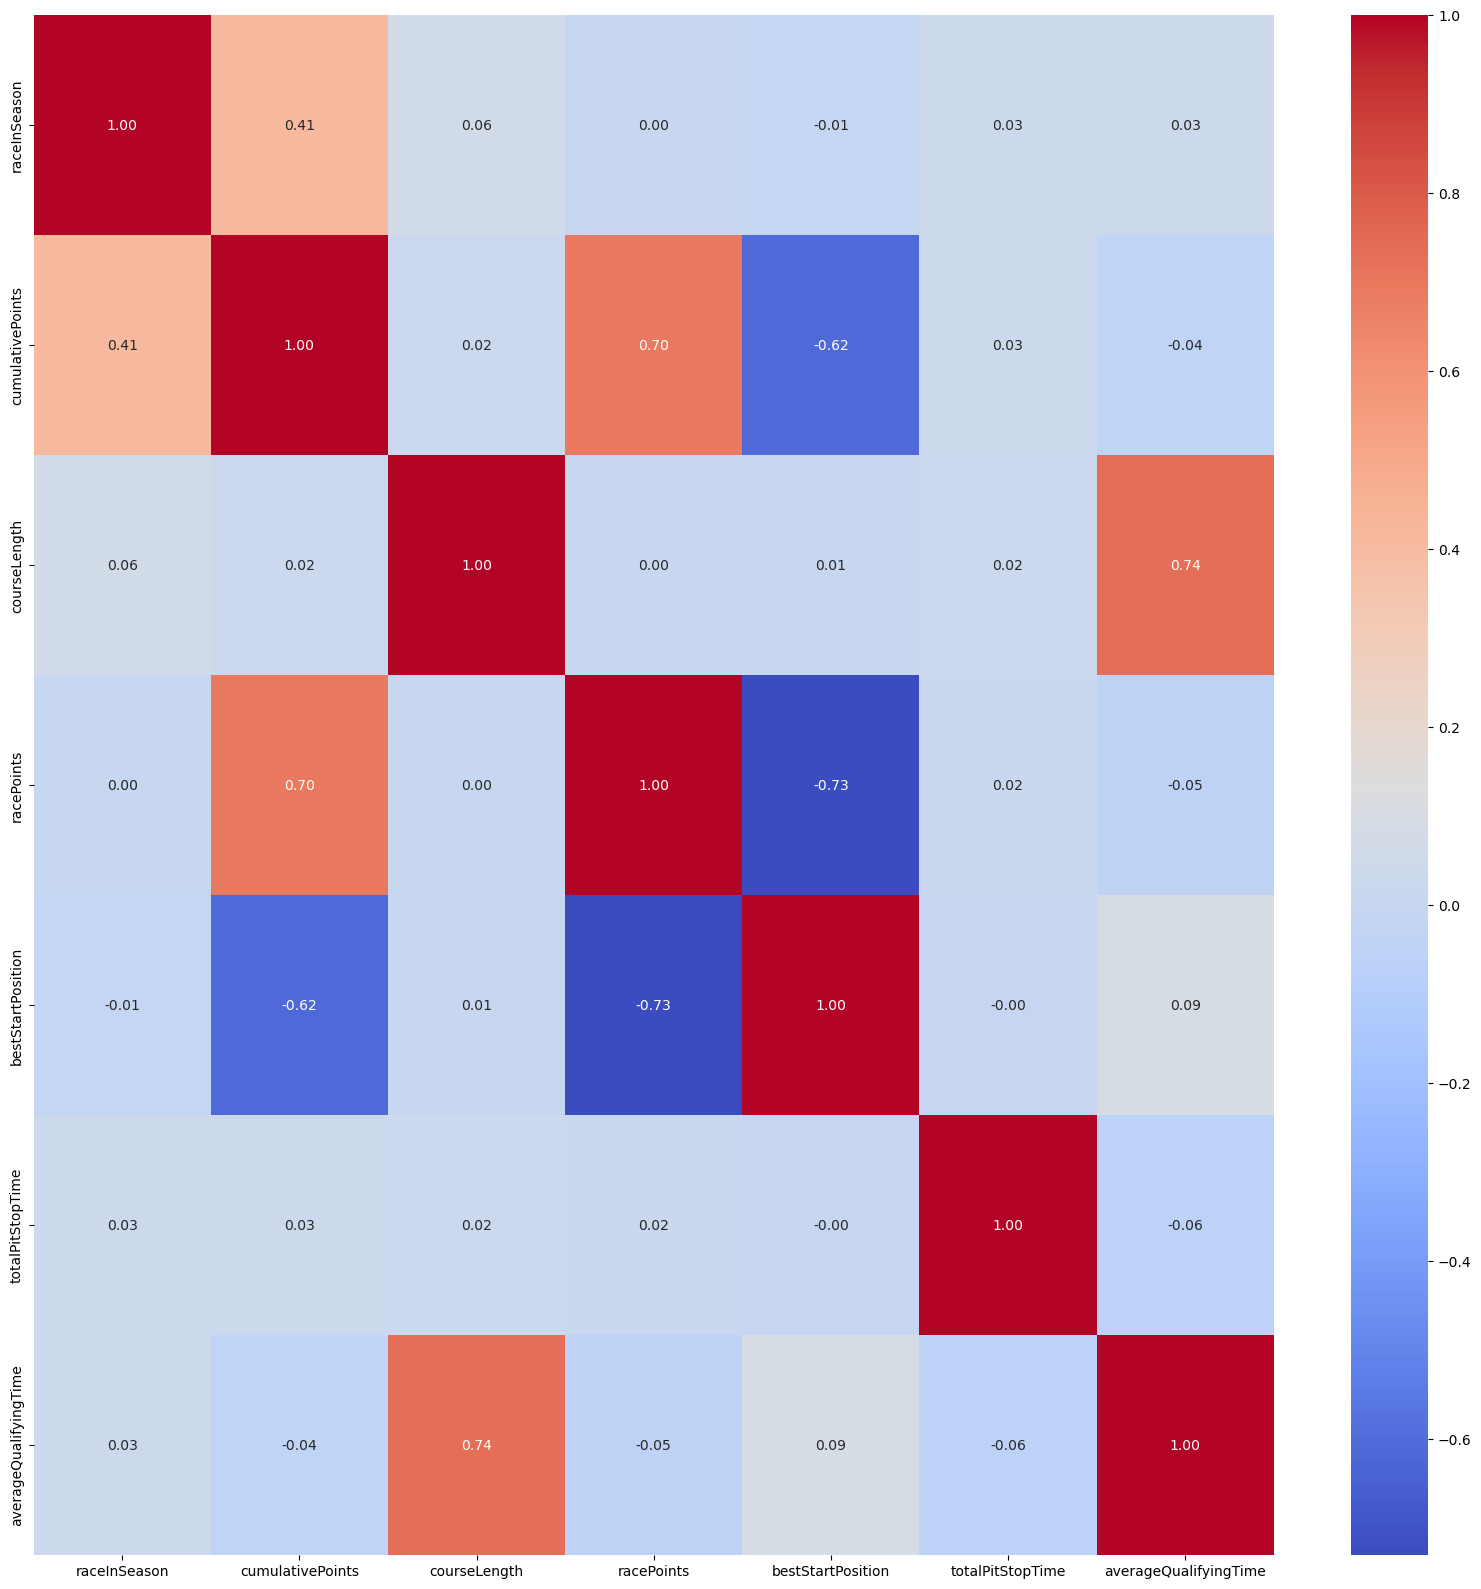

In [27]:
corr = analysis_data.drop(columns=['year', 'constructorId', 'raceId', 'officialName', 'engineManufacturerId', 'qualifyingFormat', 'circuitType']).corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10})
plt.show()

## Different Correlations to Explore

- Correlation between points scored by the constructor and the circuit type
- Correlation between points scored by the constructor and the year
- Correlation between points scored by the constructor and the race number
- Correlation between points scored by the constructor and pit stop time
- Correlation between points scored by the constructor and qualifying time
- Correlation between points scored by the constructor and qualifying format
- Correlation between points scored by the constructor and engine manufacturer
- Correlation between points scored by the constructor and course length

## Hypothesis

# Decision Model